In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import random
import os
import cv2
import random
import os
from sklearn import model_selection, utils
from scipy import ndimage

In [2]:
def get_labels(label_file):
    """lê a tabela com as informações dos pacientes e retorna uma matriz com o ID e as labels"""
    labels = pd.read_csv(label_file)
    cancer_labels = dict()

    for p in labels.index:
        cancer_labels[labels['PatientID'][p]] = [int(labels['Normal'][p]), int(labels['Actionable'][p]), int(labels['Benign'][p]), int(labels['Cancer'][p])]

    return cancer_labels

In [3]:
labels = get_labels('/kaggle/input/labelsssss/labels.csv')
numbers_per_class = [0, 0, 0, 0]
for i in labels:
    numbers_per_class[np.argmax(labels[i])] += 1

proportion_per_class = [round(number_of_class/sum(numbers_per_class), 3) for number_of_class in numbers_per_class]
proportion_per_class

[0.348, 0.253, 0.232, 0.167]

In [4]:
path = '/kaggle/input/320x240xdepth/'

X = [path + i for i in os.listdir(path)]
y = [np.argmax(labels[i[-14:-4]]) for i in os.listdir(path)]

In [5]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, stratify=y, random_state=42, train_size=0.8)

In [6]:
numbers_per_class = [0, 0, 0, 0]
for i in X_train:
    numbers_per_class[np.argmax(labels[i[-14:-4]])] += 1

proportion_per_class = [round(number_of_class/sum(numbers_per_class), 3) for number_of_class in numbers_per_class]
proportion_per_class

[0.362, 0.266, 0.243, 0.13]

In [7]:
numbers_per_class = [0, 0, 0, 0]
for i in X_test:
    numbers_per_class[np.argmax(labels[i[-14:-4]])] += 1

proportion_per_class = [round(number_of_class/sum(numbers_per_class), 3) for number_of_class in numbers_per_class]
proportion_per_class

[0.356, 0.267, 0.244, 0.133]

In [8]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, objective, list_IDs, labels_dir, batch_size, sub_batch_size, dim_img, training, shuffle=True):
        self.objective = objective # list representing one hot encoding for choice label ([1, 0, 0, 0] for normal, [0, 0, 0, 1] for cancer ..)
        self.list_IDs = list_IDs # array of strings with original images name with directory
        self.labels = self.__get_labels(labels_dir) #dict with labels of all images
        self.batch_size = batch_size #images per batch
        self.sub_batch_size = sub_batch_size #slices of the images in batch
        self.dim_img = dim_img # tuple with width and height of image like (240, 320)
        self.training = training # true if generator is for training, false if generator is for validation
        self.shuffle = shuffle # true or false to shuffle data after any epochs
        self.on_epoch_end() # call of the function
        
    def __separate_slices(self, img):
        'function to separate 2d images of 3d original image'
        slices = []

        for i in range(img.shape[-2]):
            slices.append(np.array(img[:, :, i]))

        slices.append(np.mean(img, axis=-2)) #including mean of slices
        
        return slices
    
    def __get_labels(self, label_file):
        'take the dict with labels of images'
        labels = pd.read_csv(label_file)
        cancer_labels = dict()

        for p in labels.index:
            cancer_labels[labels['PatientID'][p]] = [int(labels['Normal'][p]), int(labels['Actionable'][p]), int(labels['Benign'][p]), int(labels['Cancer'][p])]

        return cancer_labels
    
    def __data_augmentation(self, x):
        'generate variations of images'
        new_images = []

        new_images.append(x.astype('float16'))
        """
        new_images.append(
            ndimage.rotate(x.astype('float32'), angle=10, axes=(1, 0), reshape=False).astype(
                'float16'))
        new_images.append(
            ndimage.rotate(x.astype('float32'), angle=-10, axes=(1, 0), reshape=False).astype(
                'float16'))
        """

        x = cv2.flip(x.astype('float32'), 1).astype('float16')
        new_images.append(np.expand_dims(x, -1))
        """
        new_images.append(
            ndimage.rotate(np.expand_dims(x, -1).astype('float32'), angle=10, axes=(1, 0), reshape=False).astype(
                'float16'))
        new_images.append(
            ndimage.rotate(np.expand_dims(x, -1).astype('float32'), angle=-10, axes=(1, 0), reshape=False).astype(
                'float16'))
        """

        return new_images

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    

    def __getitem__(self, index):        
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        if self.training:
            X, y = X[0:self.sub_batch_size], y[0:self.sub_batch_size]
        
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'
        X = []
        y = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            prev_len_X = len(X)
            full_image = np.load(ID)
            new_images = self.__separate_slices(full_image)
            if self.training:
                for img in new_images:
                    X += self.__data_augmentation(img)
            else:
                X = new_images
            
            #adding new data labels for y array
            for _ in range(len(X) - prev_len_X):
                #y.append(self.labels[ID[-14:-4]])
                if self.labels[ID[-14:-4]] == self.objective: #'-14:-4 represent a part of string with name of original image that slices was taken'
                    y.append(1)
                else:
                    y.append(0)
                
        X, y = utils.shuffle(X, y)

        return np.array(X), np.array(y)

In [9]:
class layer(tf.keras.layers.Layer):
    pass

In [10]:
def get_model():
    pass


In [11]:
histories = []
n_splits = 5
skf = model_selection.StratifiedShuffleSplit(n_splits=n_splits, random_state=51)
dirs = os.listdir('/kaggle/input/320x240xdepth/')
for number_of_split, data in enumerate(skf.split(X_train, y_train)):
    print(f'SPLIT {number_of_split+1}/{n_splits}:')
    train = [path + dirs[i] for i in data[0]]
    val = [path + dirs[j] for j in data[1]]
    
    # Generators
    training_generator = DataGenerator(objective=[1, 0, 0, 0],
                                       list_IDs=train, 
                                       labels_dir='/kaggle/input/labelsssss/labels.csv', 
                                       dim_img=(240, 320), 
                                       batch_size=2,
                                       sub_batch_size=160,
                                       shuffle=True, 
                                       training=True)
    
    validation_generator = DataGenerator(objective=[1, 0, 0, 0],
                                         list_IDs=val, 
                                         labels_dir='/kaggle/input/labelsssss/labels.csv', 
                                         dim_img=(240, 320), 
                                         batch_size=1,
                                         sub_batch_size="IGNORED!", #ignored because it's generator is for validation
                                         shuffle=True, 
                                         training=False)
    # Resnet model
    resnet34 = get_model()
    resnet34.compile(loss='binary_crossentropy', 
                     optimizer=tf.keras.optimizers.Adam(1e-5),
                     metrics=[tf.keras.metrics.AUC(name='AUC'),
                              tf.keras.metrics.BinaryAccuracy(name='acc'),
                              tf.keras.metrics.FalseNegatives(name='fn')]) 
                                                               

    # Train model on dataset
    histories.append(resnet34.fit(training_generator,
                              validation_data=validation_generator, 
                              epochs=10,
                              use_multiprocessing=True,
                              workers=1))
    print('\n')

SPLIT 1/5:
Epoch 1/10
79/79 [==============================] - 159s 2s/step - loss: 0.7054 - auc: 0.5165 - acc: 0.5544 - fn: 3085.0000 - val_loss: 0.6257 - val_auc: 0.4014 - val_acc: 0.7206 - val_fn: 352.0000
Epoch 2/10
79/79 [==============================] - 95s 1s/step - loss: 0.6786 - auc: 0.5647 - acc: 0.6052 - fn: 3278.0000 - val_loss: 0.5942 - val_auc: 0.3661 - val_acc: 0.7206 - val_fn: 352.0000
Epoch 3/10
79/79 [==============================] - 105s 1s/step - loss: 0.6310 - auc: 0.6745 - acc: 0.6304 - fn: 3673.0000 - val_loss: 0.6195 - val_auc: 0.6251 - val_acc: 0.7206 - val_fn: 352.0000
Epoch 4/10
79/79 [==============================] - 91s 1s/step - loss: 0.6214 - auc: 0.6734 - acc: 0.6542 - fn: 3601.0000 - val_loss: 0.6487 - val_auc: 0.5219 - val_acc: 0.7492 - val_fn: 251.0000
Epoch 5/10
79/79 [==============================] - 94s 1s/step - loss: 0.5933 - auc: 0.7119 - acc: 0.6933 - fn: 3148.0000 - val_loss: 0.6419 - val_auc: 0.5901 - val_acc: 0.7754 - val_fn: 281.0000
Ep

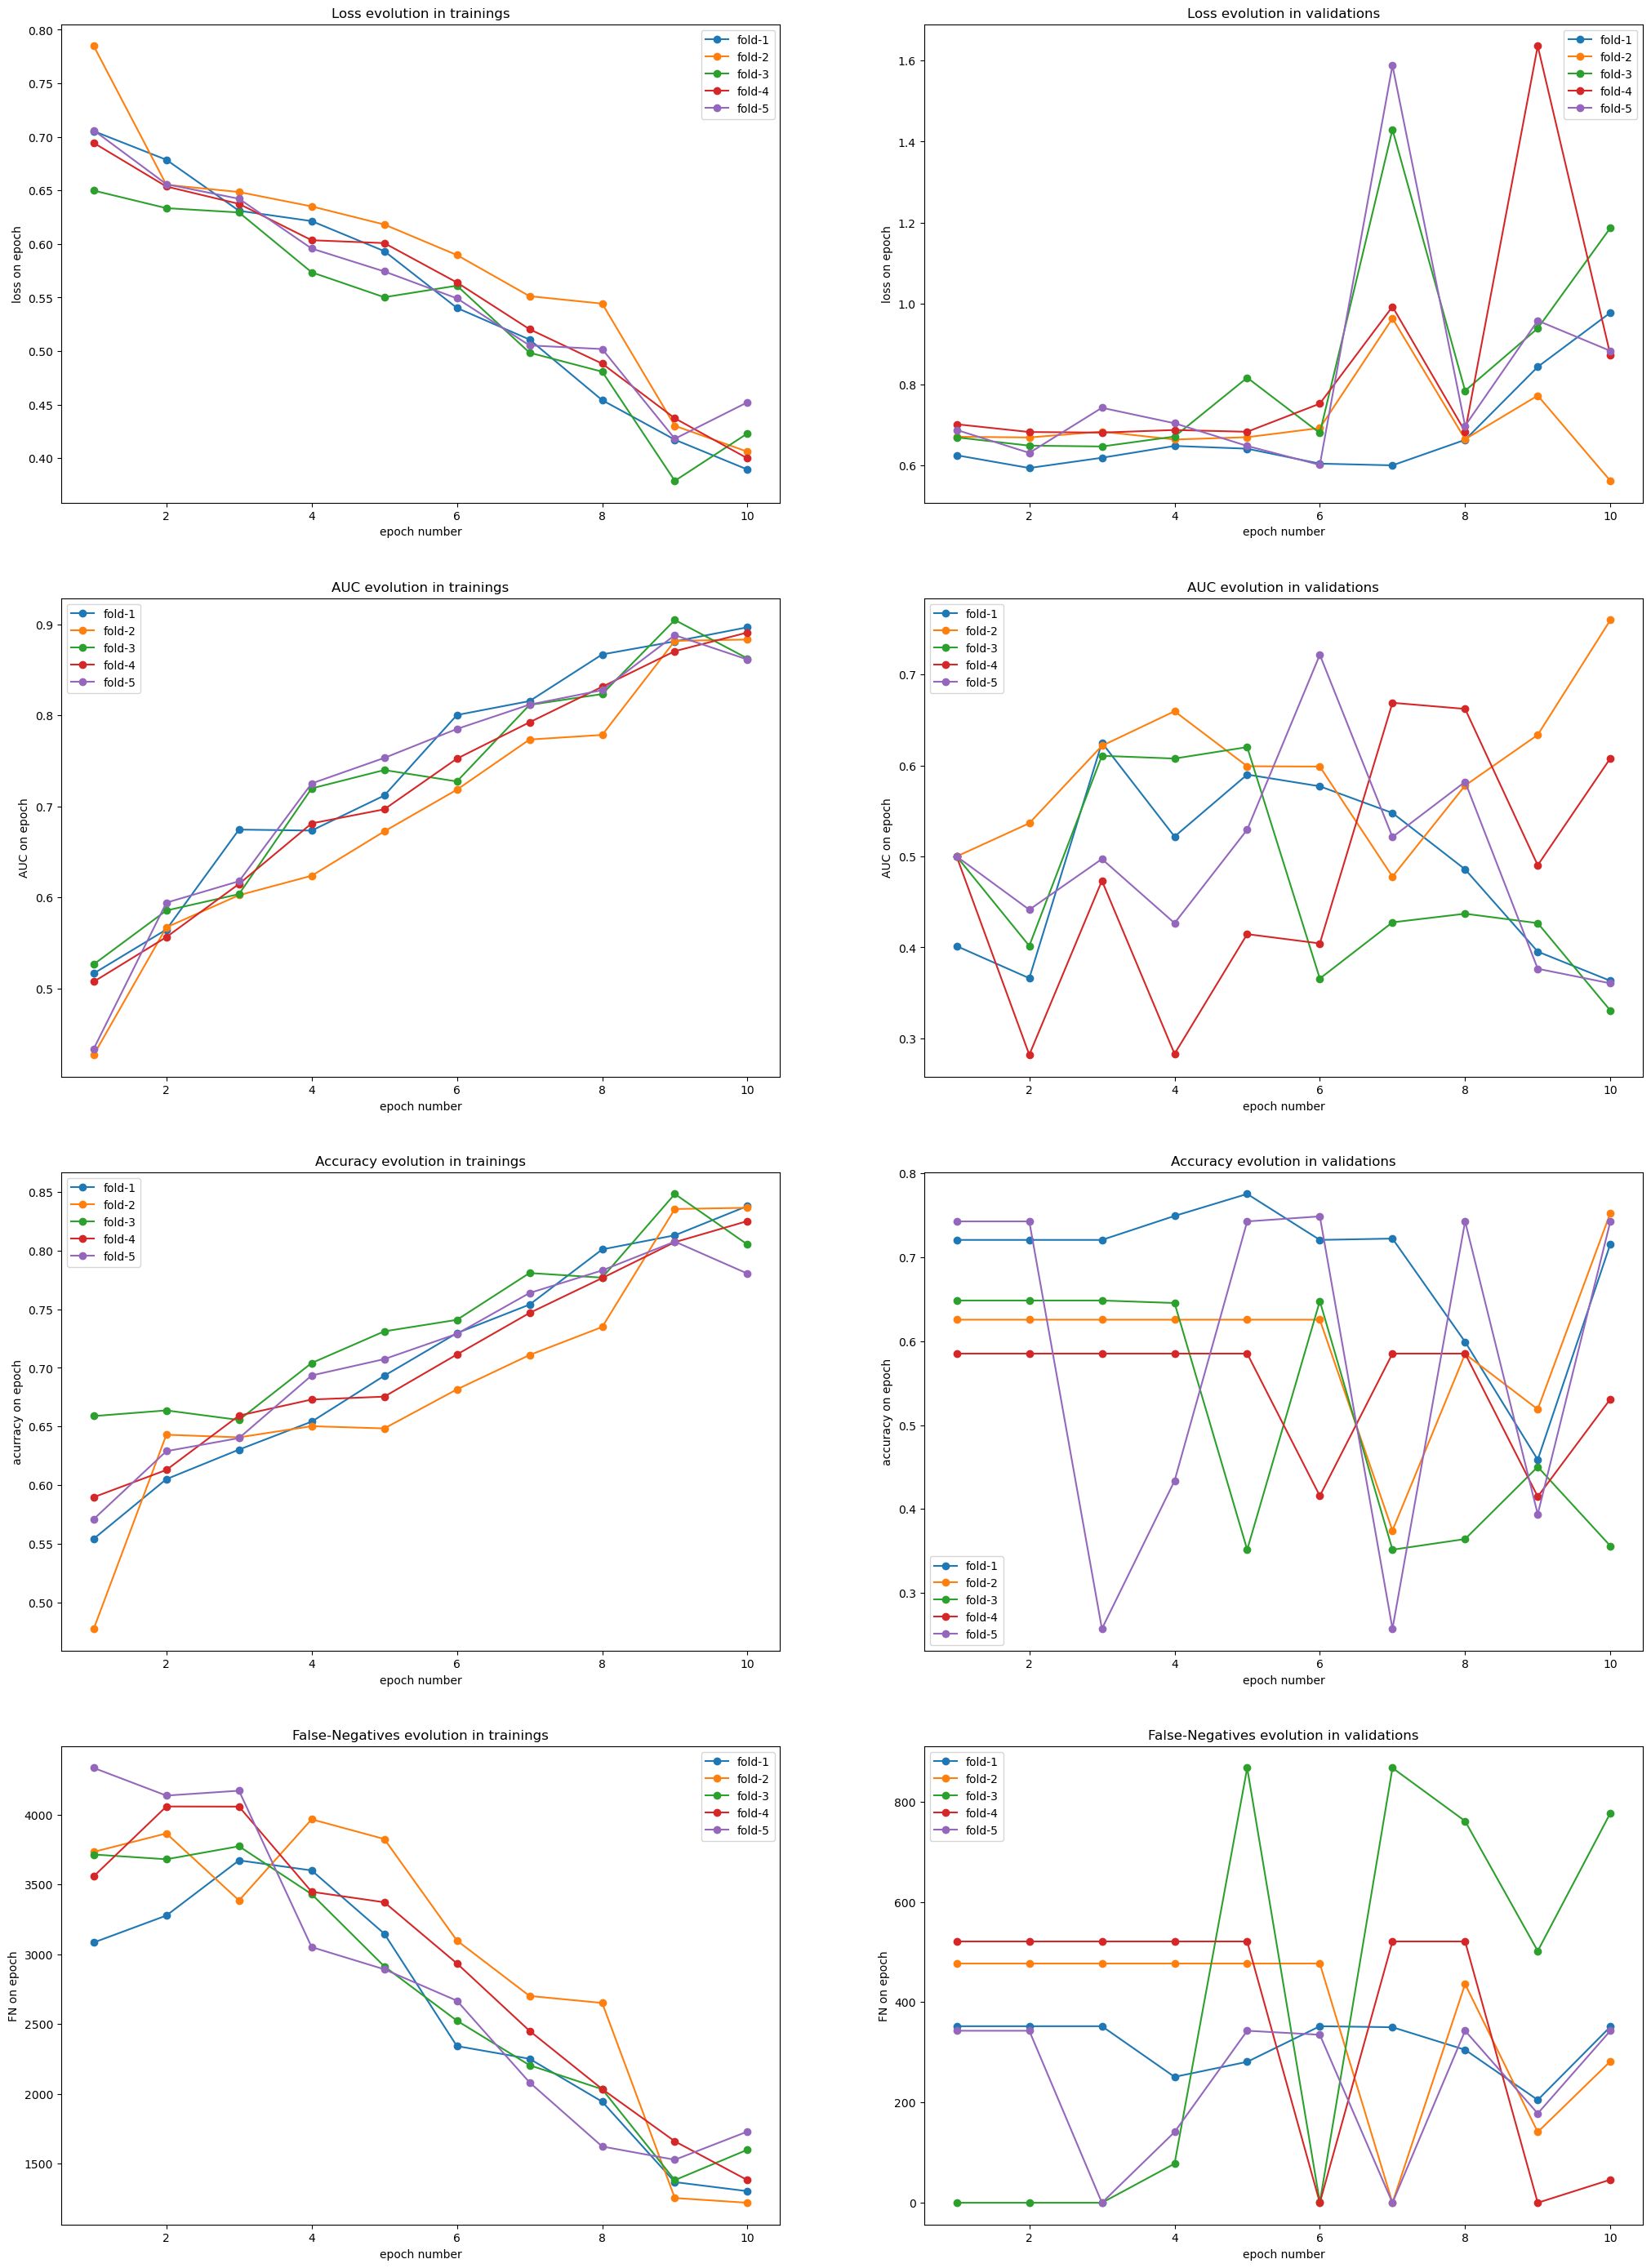

In [35]:
#generalist plotting of k-folds training

plt.figure(figsize=(25, 35))
plt.subplot(4, 2, 1)
for i, h in enumerate(histories):
    plt.plot(list(range(1, 11)), h.history['loss'], marker='o')
plt.title('Binary Cross Entropy evolution in trainings')
plt.xlabel('epoch number')
plt.ylabel('loss on epoch')
plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 2)
for i, h in enumerate(histories):
    plt.plot(list(range(1, 11)), h.history['val_loss'], marker='o')
plt.title('Binary Cross Entropy evolution in validations')
plt.xlabel('epoch number')
plt.ylabel('loss on epoch')
plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])


plt.subplot(4, 2, 3)
for i, h in enumerate(histories):
    plt.plot(list(range(1, 11)), h.history['auc'], marker='o')
plt.title('AUC evolution in trainings')
plt.xlabel('epoch number')
plt.ylabel('AUC on epoch')
plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 4)
for i, h in enumerate(histories):
    plt.plot(list(range(1, 11)), h.history['val_auc'], marker='o')
plt.title('AUC evolution in validations')
plt.xlabel('epoch number')
plt.ylabel('AUC on epoch')
plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])


plt.subplot(4, 2, 5)
for i, h in enumerate(histories):
    plt.plot(list(range(1, 11)), h.history['acc'], marker='o')
plt.title('Accuracy evolution in trainings')
plt.xlabel('epoch number')
plt.ylabel('acurracy on epoch')
plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 6)
for i, h in enumerate(histories):
    plt.plot(list(range(1, 11)), h.history['val_acc'], marker='o')
plt.title('Accuracy evolution in validations')
plt.xlabel('epoch number')
plt.ylabel('accuracy on epoch')
plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])


plt.subplot(4, 2, 7)
for i, h in enumerate(histories):
    plt.plot(list(range(1, 11)), h.history['fn'], marker='o')
plt.title('False-Negatives evolution in trainings')
plt.xlabel('epoch number')
plt.ylabel('FN on epoch')
plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 8)
for i, h in enumerate(histories):
    plt.plot(list(range(1, 11)), h.history['val_fn'], marker='o')
plt.title('False-Negatives evolution in validations')
plt.xlabel('epoch number')
plt.ylabel('FN on epoch')
plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])